In [7]:
import datetime
import warnings
from collections import Counter
from io import StringIO
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from joblib import dump
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, roc_curve, auc, \
    roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import datetime
import logging
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

SCORING = {'accuracy': 'accuracy', 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'AUC': make_scorer(roc_auc_score)}

## Data preprocessing

In [8]:
#importing data and creating test/train features
dfApache = pd.read_excel('ApacheSample.xlsx')
dfJunit = pd.read_excel('junitSample.xlsx')
dfOkhttp =  pd.read_excel('okhttpSample.xlsx')
dfRetrofit = pd.read_excel('retrofitSample.xlsx')
dfSpringBoot = pd.read_excel('springBootSample.xlsx')
# Specify the column name for the labels
label_column = 'label'
message_column = 'new_message1'

def mylog():
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    logfile = "./log/" + str(datetime.datetime.now().month) + "-" + str(datetime.datetime.now().day) + "-" + str(
        datetime.datetime.now().hour) + "-" + str(datetime.datetime.now().minute) + \
              os.path.split(__file__)[-1].split(".")[0] + '.log'
    fileHandler = logging.FileHandler(logfile, mode='w', encoding='UTF-8')
    fileHandler.setLevel(logging.NOTSET)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fileHandler.setFormatter(formatter)
    logger.addHandler(fileHandler)
    return logger

# Define the preprocess_text function to perform text preprocessing steps
def preprocess_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_text = [stemmer.stem(word) for word in filtered_text]

    # Join the processed words back into a single string
    preprocessed_text = ' '.join(stemmed_text)
    
    return preprocessed_text

# Preprocess the commit message text
dfApache['new_message1'] = dfApache['new_message1'].apply(preprocess_text)
dfJunit['new_message1'] = dfJunit['new_message1'].apply(preprocess_text)
dfOkhttp['new_message1'] = dfOkhttp['new_message1'].apply(preprocess_text)
dfRetrofit['new_message1'] = dfRetrofit['new_message1'].apply(preprocess_text)
dfSpringBoot['new_message1'] = dfSpringBoot['new_message1'].apply(preprocess_text)

#splitting the data
apacheTrain, apacheTest = train_test_split(dfApache, test_size=0.15, random_state=42)
junitTrain, junitTest = train_test_split(dfJunit, test_size=0.15, random_state=42)
okhttpTrain, okhttpTest= train_test_split(dfOkhttp, test_size=0.15, random_state=42)
retrofitTrain, retrofitTest = train_test_split(dfRetrofit, test_size=0.15, random_state=42)
springBootTrain, springBootTest = train_test_split(dfSpringBoot, test_size=0.15, random_state=42)

# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_trainApache = vectorizer.fit_transform(apacheTrain['new_message1'])
X_testApache = vectorizer.transform(apacheTest['new_message1'])

X_trainJunit = vectorizer.fit_transform(junitTrain['new_message1'])
X_testJunit = vectorizer.transform(junitTest['new_message1'])

X_trainOkhttp = vectorizer.fit_transform(okhttpTrain['new_message1'])
X_testOkhttp = vectorizer.transform(okhttpTest['new_message1'])

X_trainRetrofit = vectorizer.fit_transform(retrofitTrain['new_message1'])
X_testRetrofit = vectorizer.transform(retrofitTest['new_message1'])

X_trainSpringboot = vectorizer.fit_transform(springBootTrain['new_message1'])
X_testSpringboot = vectorizer.transform(springBootTest['new_message1'])

# Get the corresponding labels for the training and test sets
y_trainApache = apacheTrain[label_column]
y_testApache = apacheTest[label_column]

y_trainJunit = junitTrain[label_column]
y_testJunit = junitTest[label_column]

y_trainOkhttp = okhttpTrain[label_column]
y_testOkhttp = okhttpTest[label_column]

y_trainRetrofit = retrofitTrain[label_column]
y_testRetrofit = retrofitTest[label_column]

y_trainSpringboot = springBootTrain[label_column]
y_testSpringboot = springBootTest[label_column]

## Logistic model

In [9]:
import warnings

def get_score_by_grid(grid: GridSearchCV):
    print("GridSearchCV is complete!")
    accuRank = grid.cv_results_['rank_test_accuracy']
    preMean = grid.cv_results_['mean_test_precision']
    bestParam = grid.cv_results_['params']
    bestIndex = grid.best_index_
    i = bestIndex
    rank = 1

    while preMean[i] < 0.5:
        rank += 1
        indx = 0
        if rank > 20:
            break
        for num in accuRank:
            if num == rank:
                i = indx
                break
            indx += 1
    bestIndex = i

    res = "refit by:" + str(grid.refit) + " Parameters: " + str(bestParam[bestIndex])
    return bestParam[bestIndex]


def LRClassifier(trainFeatures, trainLabels):
    parameters = {'C': np.linspace(0.0001, 20, 20),
                  'random_state': np.arange(1, 5),
                  'solver': ["newton-cg", "lbfgs", "liblinear", "sag"],
                  'multi_class': ['ovr'],
                  'dual': [False],
                  'verbose': [False],
                  'max_iter': [500]
                  }
    fold = KFold(n_splits=10, random_state=5, shuffle=True)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid = GridSearchCV(LogisticRegression(), parameters, scoring=SCORING, refit="accuracy", cv=fold, n_jobs=25)
        grid.fit(trainFeatures, trainLabels)
    
    bestParameter = get_score_by_grid(grid)
    print("LR Best: using %s " % (bestParameter))
    model = LogisticRegression(C=bestParameter['C'], random_state=bestParameter['random_state'],
                               solver=bestParameter['solver'], multi_class='ovr', dual=False, verbose=False,
                               max_iter=500)
    return model



In [1]:
##### do not run for now

In [ ]:
import warnings

# Generating model results for each project
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    LRModelApache = LRClassifier(X_trainApache, y_trainApache)
    LRModelApache.fit(X_trainApache, y_trainApache)

    LRModelJunit = LRClassifier(X_trainJunit, y_trainJunit)
    LRModelJunit.fit(X_trainJunit, y_trainJunit)

    LRModelOkhttp = LRClassifier(X_trainOkhttp, y_trainOkhttp)
    LRModelOkhttp.fit(X_trainOkhttp, y_trainOkhttp)

    LRModelRetrofit = LRClassifier(X_trainRetrofit, y_trainRetrofit)
    LRModelRetrofit.fit(X_trainRetrofit, y_trainRetrofit)

    LRModelSpringboot = LRClassifier(X_trainSpringboot, y_trainSpringboot)
    LRModelSpringboot.fit(X_trainSpringboot, y_trainSpringboot)

# Generating predicts and model accuracy
predictionsApache = LRModelApache.predict(X_testApache)
accuracyApache = accuracy_score(y_testApache, predictionsApache)

predictionsJunit = LRModelJunit.predict(X_testJunit)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)

predictionsOkhttp = LRModelOkhttp.predict(X_testOkhttp)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)

predictionsRetrofit = LRModelRetrofit.predict(X_testRetrofit)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)

predictionsSpringboot = LRModelSpringboot.predict(X_testSpringboot)
accuracySpringboot = accuracy_score(y_testSpringboot, predictionsSpringboot)

# Filter the test labels and predictions for c-why and c-what categories (label = 0)
test_labelsApache = apacheTest[label_column]
c_why_what_labelsApache = test_labelsApache[test_labelsApache == 0]
c_why_what_predictionsApache = predictionsApache[test_labelsApache == 0]

test_labelsJunit = junitTest[label_column]
c_why_what_labelsJunit = test_labelsJunit[test_labelsJunit == 0]
c_why_what_predictionsJunit = predictionsJunit[test_labelsJunit == 0]

test_labelsOkhttp = okhttpTest[label_column]
c_why_what_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 0]
c_why_what_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 0]

test_labelsRetrofit = retrofitTest[label_column]
c_why_what_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 0]
c_why_what_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 0]

test_labelsSpringboot = springBootTest[label_column]
c_why_what_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 0]
c_why_what_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 0]

# Calculate accuracy for c-why and c-what combined category
c_why_what_accuracyApache = accuracy_score(c_why_what_labelsApache, c_why_what_predictionsApache)
c_why_what_accuracyJunit = accuracy_score(c_why_what_labelsJunit, c_why_what_predictionsJunit)
c_why_what_accuracyOkhttp = accuracy_score(c_why_what_labelsOkhttp, c_why_what_predictionsOkhttp)
c_why_what_accuracyRetrofit = accuracy_score(c_why_what_labelsRetrofit, c_why_what_predictionsRetrofit)
c_why_what_accuracySpringboot = accuracy_score(c_why_what_labelsSpringboot, c_why_what_predictionsSpringboot)


In [11]:
#Displaying results
print("\n")
print("Accuracy Overall for Apache Project:", accuracyApache)
print("Accuracy (c-why and c-what) for Apache Project:", c_why_what_accuracyApache)
print("Training set shape for Apache Project:", apacheTrain.shape)
print("Test set shape for Apache Project:", apacheTest.shape)
print("\n")
print("Accuracy Overall for Junit Project:", accuracyJunit)
print("Accuracy (c-why and c-what) for Junit Project:", c_why_what_accuracyJunit)
print("Training set shape for Junit Project:", junitTrain.shape)
print("Test set shape for Junit Project:", junitTest.shape)
print("\n")
print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
print("Accuracy (c-why and c-what) for Okhttp Project:", c_why_what_accuracyOkhttp)
print("Training set shape for Okhttp Project:", okhttpTrain.shape)
print("Test set shape for Okhttp Project:", okhttpTest.shape)
print("\n")
print("Accuracy Overall for Retrofit Project:", accuracyRetrofit)
print("Accuracy (c-why and c-what) for Retrofit Project:", c_why_what_accuracyRetrofit)
print("Training set shape for Retrofit Project:", retrofitTest.shape)
print("Test set shape for Retrofit Project:", retrofitTrain.shape)
print("\n")
print("Accuracy Overall for Springboot Project:", accuracySpringboot)
print("Accuracy (c-why and c-what) for Springboot Project:", c_why_what_accuracySpringboot)
print("Training set shape for Springboot Project:", springBootTest.shape)
print("Test set shape for Springboot Project:", springBootTrain.shape)



Accuracy Overall for Apache Project: 0.62
Accuracy (c-why and c-what) for Apache Project: 0.8064516129032258
Training set shape for Apache Project: (278, 9)
Test set shape for Apache Project: (50, 9)


Accuracy Overall for Junit Project: 0.5102040816326531
Accuracy (c-why and c-what) for Junit Project: 0.7857142857142857
Training set shape for Junit Project: (273, 9)
Test set shape for Junit Project: (49, 9)


Accuracy Overall for Okhttp Project: 0.7254901960784313
Accuracy (c-why and c-what) for Okhttp Project: 0.8888888888888888
Training set shape for Okhttp Project: (287, 9)
Test set shape for Okhttp Project: (51, 9)


Accuracy Overall for Retrofit Project: 0.7441860465116279
Accuracy (c-why and c-what) for Retrofit Project: 0.75
Training set shape for Retrofit Project: (43, 9)
Test set shape for Retrofit Project: (240, 9)


Accuracy Overall for Springboot Project: 0.8771929824561403
Accuracy (c-why and c-what) for Springboot Project: 0.9583333333333334
Training set shape for Spri

## BI-LSTM

In [12]:
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

# Set the maximum number of words to consider in the text
MAX_WORDS = 10000
# Set the maximum length of each input sequence
MAX_SEQUENCE_LENGTH = 100

# Convert the text data into sequences of integers
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(dfApache['new_message1'])
tokenizer.fit_on_texts(dfJunit['new_message1'])
tokenizer.fit_on_texts(dfOkhttp['new_message1'])
tokenizer.fit_on_texts(dfRetrofit['new_message1'])
tokenizer.fit_on_texts(dfSpringBoot['new_message1'])

sequencesApache = tokenizer.texts_to_sequences(dfApache['new_message1'])
sequencesJunit = tokenizer.texts_to_sequences(dfJunit['new_message1'])
sequencesOkhttp = tokenizer.texts_to_sequences(dfOkhttp['new_message1'])
sequencesRetrofit = tokenizer.texts_to_sequences(dfRetrofit['new_message1'])
sequencesSpringBoot = tokenizer.texts_to_sequences(dfSpringBoot['new_message1'])

# Pad the sequences to have the same length
padded_sequencesApache = pad_sequences(sequencesApache, maxlen=MAX_SEQUENCE_LENGTH)
padded_sequencesJunit = pad_sequences(sequencesJunit, maxlen=MAX_SEQUENCE_LENGTH)
padded_sequencesOkhttp = pad_sequences(sequencesOkhttp, maxlen=MAX_SEQUENCE_LENGTH)
padded_sequencesRetrofit = pad_sequences(sequencesRetrofit, maxlen=MAX_SEQUENCE_LENGTH)
padded_sequencesSpringBoot = pad_sequences(sequencesSpringBoot, maxlen=MAX_SEQUENCE_LENGTH)

# Split the data into training and test sets
X_trainApache, X_testApache, y_trainApache, y_testApache = train_test_split(
    padded_sequencesApache, dfApache[label_column], test_size=0.15, random_state=42)
X_trainJunit, X_testJunit, y_trainJunit, y_testJunit = train_test_split(
    padded_sequencesJunit, dfJunit[label_column], test_size=0.15, random_state=42)
X_trainOkhttp, X_testOkhttp, y_trainOkhttp, y_testOkhttp = train_test_split(
    padded_sequencesOkhttp, dfOkhttp[label_column], test_size=0.15, random_state=42)
X_trainRetrofit, X_testRetrofit, y_trainRetrofit, y_testRetrofit = train_test_split(
    padded_sequencesRetrofit, dfRetrofit[label_column], test_size=0.15, random_state=42)
X_trainSpringboot, X_testSpringboot, y_trainSpringboot, y_testSpringboot = train_test_split(
    padded_sequencesSpringBoot, dfSpringBoot[label_column], test_size=0.15, random_state=42)

# Define the Bi-LSTM model
modelApache = Sequential()
modelApache.add(Embedding(MAX_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
modelApache.add(Bidirectional(LSTM(64, return_sequences=True)))
modelApache.add(Bidirectional(LSTM(64)))
modelApache.add(Dense(1, activation='sigmoid'))

modelJunit = Sequential()
modelJunit.add(Embedding(MAX_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
modelJunit.add(Bidirectional(LSTM(64, return_sequences=True)))
modelJunit.add(Bidirectional(LSTM(64)))
modelJunit.add(Dense(1, activation='sigmoid'))

modelOkhttp = Sequential()
modelOkhttp.add(Embedding(MAX_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
modelOkhttp.add(Bidirectional(LSTM(64, return_sequences=True)))
modelOkhttp.add(Bidirectional(LSTM(64)))
modelOkhttp.add(Dense(1, activation='sigmoid'))

modelRetrofit = Sequential()
modelRetrofit.add(Embedding(MAX_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
modelRetrofit.add(Bidirectional(LSTM(64, return_sequences=True)))
modelRetrofit.add(Bidirectional(LSTM(64)))
modelRetrofit.add(Dense(1, activation='sigmoid'))

modelSpringboot = Sequential()
modelSpringboot.add(Embedding(MAX_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
modelSpringboot.add(Bidirectional(LSTM(64, return_sequences=True)))
modelSpringboot.add(Bidirectional(LSTM(64)))
modelSpringboot.add(Dense(1, activation='sigmoid'))

# Compile the models
modelApache.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelJunit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelOkhttp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelRetrofit.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelSpringboot.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
modelApache.fit(X_trainApache, y_trainApache, epochs=10, batch_size=32, verbose=2)
modelJunit.fit(X_trainJunit, y_trainJunit, epochs=10, batch_size=32, verbose=2)
modelOkhttp.fit(X_trainOkhttp, y_trainOkhttp, epochs=10, batch_size=32, verbose=2)
modelRetrofit.fit(X_trainRetrofit, y_trainRetrofit, epochs=10, batch_size=32, verbose=2)
modelSpringboot.fit(X_trainSpringboot, y_trainSpringboot, epochs=10, batch_size=32, verbose=2)

# Evaluate the models on the test sets
predictionsApache = (modelApache.predict(X_testApache) > 0.5).astype(int)
accuracyApache = accuracy_score(y_testApache, predictionsApache)

predictionsJunit = (modelJunit.predict(X_testJunit) > 0.5).astype(int)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)

predictionsOkhttp = (modelOkhttp.predict(X_testOkhttp) > 0.5).astype(int)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)

predictionsRetrofit = (modelRetrofit.predict(X_testRetrofit) > 0.5).astype(int)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)

predictionsSpringboot = (modelSpringboot.predict(X_testSpringboot) > 0.5).astype(int)
accuracySpringboot = accuracy_score(y_testSpringboot, predictionsSpringboot)

# Display the results
print("Accuracy Overall for Apache Project:", accuracyApache)
print("Accuracy Overall for Junit Project:", accuracyJunit)
print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
print("Accuracy Overall for Retrofit Project:", accuracyRetrofit)
print("Accuracy Overall for Springboot Project:", accuracySpringboot)


Epoch 1/10
9/9 - 3s - loss: 0.4238 - accuracy: 0.0432 - 3s/epoch - 318ms/step
Epoch 2/10
9/9 - 1s - loss: 0.1532 - accuracy: 0.0432 - 602ms/epoch - 67ms/step
Epoch 3/10
9/9 - 1s - loss: 0.0484 - accuracy: 0.0432 - 585ms/epoch - 65ms/step
Epoch 4/10
9/9 - 1s - loss: -2.8948e-01 - accuracy: 0.0432 - 575ms/epoch - 64ms/step
Epoch 5/10
9/9 - 1s - loss: -8.4177e-01 - accuracy: 0.0432 - 574ms/epoch - 64ms/step
Epoch 6/10
9/9 - 1s - loss: -1.9994e+00 - accuracy: 0.0432 - 581ms/epoch - 65ms/step
Epoch 7/10
9/9 - 1s - loss: -3.9140e+00 - accuracy: 0.4820 - 585ms/epoch - 65ms/step
Epoch 8/10
9/9 - 1s - loss: -6.3191e+00 - accuracy: 0.5540 - 581ms/epoch - 65ms/step
Epoch 9/10
9/9 - 1s - loss: -8.3913e+00 - accuracy: 0.5935 - 578ms/epoch - 64ms/step
Epoch 10/10
9/9 - 1s - loss: -9.3945e+00 - accuracy: 0.5468 - 584ms/epoch - 65ms/step
Epoch 1/10
9/9 - 2s - loss: 0.2160 - accuracy: 0.1099 - 2s/epoch - 255ms/step
Epoch 2/10
9/9 - 1s - loss: -2.3674e+00 - accuracy: 0.0623 - 572ms/epoch - 64ms/step
Epo

2/2 [==============================] - 1s 16ms/step


2/2 [==============================] - 1s 16ms/step
Accuracy Overall for Apache Project: 0.32
Accuracy Overall for Junit Project: 0.30612244897959184
Accuracy Overall for Okhttp Project: 0.49019607843137253
Accuracy Overall for Retrofit Project: 0.0
Accuracy Overall for Springboot Project: 0.7719298245614035


# BERT + BI-LSTM MODEL TRAINING

In [ ]:
import warnings
import logging
import os
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split, KFold
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set the maximum sequence length and other constants
MAX_SEQUENCE_LENGTH = 100
LABEL_COLUMN = 'label'

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Convert the text data into BERT input format


input_sequencesApache = tokenizer.batch_encode_plus(dfApache['new_message1'].tolist(), 
                                                    padding='max_length', 
                                                    truncation=True,
                                                    max_length=MAX_SEQUENCE_LENGTH,
                                                    return_tensors='tf')
input_sequencesJunit = tokenizer.batch_encode_plus(dfJunit['new_message1'].tolist(), 
                                                    padding='max_length', 
                                                    truncation=True,
                                                    max_length=MAX_SEQUENCE_LENGTH,
                                                    return_tensors='tf')
input_sequencesOkhttp = tokenizer.batch_encode_plus(dfOkhttp['new_message1'].tolist(), 
                                                    padding='max_length', 
                                                    truncation=True,
                                                    max_length=MAX_SEQUENCE_LENGTH,
                                                    return_tensors='tf')
input_sequencesRetrofit = tokenizer.batch_encode_plus(dfRetrofit['new_message1'].tolist(), 
                                                    padding='max_length', 
                                                    truncation=True,
                                                    max_length=MAX_SEQUENCE_LENGTH,
                                                    return_tensors='tf')
input_sequencesSpringBoot = tokenizer.batch_encode_plus(dfSpringBoot['new_message1'].tolist(), 
                                                    padding='max_length', 
                                                    truncation=True,
                                                    max_length=MAX_SEQUENCE_LENGTH,
                                                    return_tensors='tf')



input_ids_apache = np.array(input_sequencesApache['input_ids'])

input_ids_Junit = np.array(input_sequencesJunit['input_ids'])

input_ids_Okhttp = np.array(input_sequencesOkhttp['input_ids'])

input_ids_Retrofit = np.array(input_sequencesRetrofit['input_ids'])

input_ids_SpringBoot  = np.array(input_sequencesSpringBoot ['input_ids'])


# Split the data into training and test sets
X_trainApache, X_testApache, y_trainApache, y_testApache = train_test_split(
    input_ids_apache, dfApache[LABEL_COLUMN], test_size=0.15, random_state=42)
X_trainJunit, X_testJunit, y_trainJunit, y_testJunit = train_test_split(
    input_ids_Junit, dfJunit[LABEL_COLUMN], test_size=0.15, random_state=42)
X_trainOkhttp, X_testOkhttp, y_trainOkhttp, y_testOkhttp = train_test_split(
    input_ids_Okhttp, dfOkhttp[LABEL_COLUMN], test_size=0.15, random_state=42)
X_trainRetrofit, X_testRetrofit, y_trainRetrofit, y_testRetrofit = train_test_split(
    input_ids_Retrofit, dfRetrofit[LABEL_COLUMN], test_size=0.15, random_state=42)
X_trainSpringBoot, X_testSpringBoot, y_trainSpringBoot, y_testSpringBoot = train_test_split(
    input_ids_SpringBoot, dfSpringBoot[LABEL_COLUMN], test_size=0.15, random_state=42)
# Define the BERT model

input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
bert_output = bert_model(input_layer)[0]
pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(bert_output)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(pooling_layer)


modelApache = tf.keras.Model(inputs=input_layer, outputs=output_layer)
modelJunit = tf.keras.Model(inputs=input_layer, outputs=output_layer)
modelOkhttp = tf.keras.Model(inputs=input_layer, outputs=output_layer)
modelRetrofit = tf.keras.Model(inputs=input_layer, outputs=output_layer)
modelSpringBoot = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with the appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy()

modelApache.compile(optimizer=optimizer, loss=loss, metrics=[metric])
modelJunit.compile(optimizer=optimizer, loss=loss, metrics=[metric])
modelOkhttp.compile(optimizer=optimizer, loss=loss, metrics=[metric])
modelRetrofit.compile(optimizer=optimizer, loss=loss, metrics=[metric])
modelSpringBoot.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
modelApache.fit(X_trainApache, y_trainApache, epochs=20, batch_size=32, verbose=2)
modelJunit.fit(X_trainJunit, y_trainJunit, epochs=20, batch_size=32, verbose=2)
modelOkhttp.fit(X_trainOkhttp, y_trainOkhttp, epochs=20, batch_size=32, verbose=2)
modelRetrofit.fit(X_trainRetrofit, y_trainRetrofit, epochs=20, batch_size=32, verbose=2)
modelSpringBoot.fit(X_trainSpringBoot, y_trainSpringBoot, epochs=20, batch_size=32, verbose=2)


# Evaluate the model on the test set

predictionsApache = (modelApache.predict(X_testApache) > 0.5).astype(int)
accuracyApache = accuracy_score(y_testApache, predictionsApache)
predictionsJunit = (modelJunit.predict(X_testJunit) > 0.5).astype(int)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)
predictionsOkhttp = (modelOkhttp.predict(X_testOkhttp) > 0.5).astype(int)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)
predictionsRetrofit = (modelRetrofit.predict(X_testRetrofit) > 0.5).astype(int)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)
predictionsSpringBoot = (modelSpringBoot.predict(X_testSpringBoot) > 0.5).astype(int)
accuracySpringBoot = accuracy_score(y_testSpringBoot, predictionsSpringBoot)

# Display the result
# print("Accuracy Overall for Apache Project:", accuracyApache)
# print("Accuracy Overall for Junit Project:", accuracyJunit)
# print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
# print("Accuracy Overall for Retrofit[ Project:", accuracyRetrofit)
# print("Accuracy Overall for SpringBoot Project:", accuracySpringBoott)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20


9/9 - 75s - loss: 0.1163 - binary_accuracy: 0.0432 - 75s/epoch - 8s/step
Epoch 2/20
9/9 - 66s - loss: -1.9324e-01 - binary_accuracy: 0.0576 - 66s/epoch - 7s/step
Epoch 3/20
9/9 - 65s - loss: -4.2770e-01 - binary_accuracy: 0.0791 - 65s/epoch - 7s/step
Epoch 4/20
9/9 - 67s - loss: -9.0359e-01 - binary_accuracy: 0.1187 - 67s/epoch - 7s/step
Epoch 5/20
9/9 - 67s - loss: -1.4522e+00 - binary_accuracy: 0.1942 - 67s/epoch - 7s/step
Epoch 6/20
9/9 - 67s - loss: -2.5446e+00 - binary_accuracy: 0.1583 - 67s/epoch - 7s/step
Epoch 7/20
9/9 - 68s - loss: -3.6520e+00 - binary_accuracy: 0.2626 - 68s/epoch - 8s/step
Epoch 8/20
9/9 - 71s - loss: -5.0277e+00 - binary_accuracy: 0.3094 - 71s/epoch - 8s/step
Epoch 9/20
9/9 - 72s - loss: -5.9820e+00 - binary_accuracy: 0.3094 - 72s/epoch - 8s/step
Epoch 10/20
9/9 - 67s - loss: -7.1351e+00 - binary_accuracy: 0.3921 - 67s/epoch - 7s/step
Epoch 11/20
9/9 - 70s - loss: -7.3081e+00 - binary_accuracy: 0.4640 - 70s/epoch - 8s/step
Epoch 12/20
9/9 - 70s - loss: -8.35

9/9 - 97s - loss: -1.0206e+01 - binary_accuracy: 0.3757 - 97s/epoch - 11s/step
Epoch 2/20
9/9 - 106s - loss: -1.1046e+01 - binary_accuracy: 0.0916 - 106s/epoch - 12s/step
Epoch 3/20
9/9 - 100s - loss: -1.1571e+01 - binary_accuracy: 0.1172 - 100s/epoch - 11s/step
Epoch 4/20
9/9 - 89s - loss: -1.2013e+01 - binary_accuracy: 0.1538 - 89s/epoch - 10s/step
Epoch 5/20
9/9 - 84s - loss: -1.2257e+01 - binary_accuracy: 0.1502 - 84s/epoch - 9s/step
Epoch 6/20
9/9 - 82s - loss: -1.2645e+01 - binary_accuracy: 0.1795 - 82s/epoch - 9s/step
Epoch 7/20
9/9 - 76s - loss: -1.2997e+01 - binary_accuracy: 0.1722 - 76s/epoch - 8s/step
Epoch 8/20
9/9 - 76s - loss: -1.2942e+01 - binary_accuracy: 0.1941 - 76s/epoch - 8s/step
Epoch 9/20
9/9 - 68s - loss: -1.3696e+01 - binary_accuracy: 0.2088 - 68s/epoch - 8s/step
Epoch 10/20
9/9 - 87s - loss: -1.4165e+01 - binary_accuracy: 0.2161 - 87s/epoch - 10s/step
Epoch 11/20
9/9 - 79s - loss: -1.4450e+01 - binary_accuracy: 0.2418 - 79s/epoch - 9s/step
Epoch 12/20
9/9 - 84s

9/9 - 91s - loss: -8.3681e+00 - binary_accuracy: 0.2661 - 91s/epoch - 10s/step
Epoch 2/20
9/9 - 77s - loss: -7.6556e+00 - binary_accuracy: 0.1533 - 77s/epoch - 9s/step
Epoch 3/20
9/9 - 74s - loss: -1.1081e+01 - binary_accuracy: 0.3624 - 74s/epoch - 8s/step
Epoch 4/20
9/9 - 77s - loss: -1.0462e+01 - binary_accuracy: 0.4251 - 77s/epoch - 9s/step
Epoch 5/20
9/9 - 78s - loss: -1.1653e+01 - binary_accuracy: 0.2195 - 78s/epoch - 9s/step
Epoch 6/20
9/9 - 76s - loss: -1.1590e+01 - binary_accuracy: 0.2230 - 76s/epoch - 8s/step
Epoch 7/20
9/9 - 76s - loss: -1.2328e+01 - binary_accuracy: 0.3833 - 76s/epoch - 8s/step
Epoch 8/20
9/9 - 73s - loss: -1.2471e+01 - binary_accuracy: 0.4390 - 73s/epoch - 8s/step
Epoch 9/20
9/9 - 78s - loss: -1.2703e+01 - binary_accuracy: 0.4460 - 78s/epoch - 9s/step
Epoch 10/20
9/9 - 75s - loss: -1.3161e+01 - binary_accuracy: 0.3902 - 75s/epoch - 8s/step
Epoch 11/20
9/9 - 74s - loss: -1.3186e+01 - binary_accuracy: 0.4216 - 74s/epoch - 8s/step
Epoch 12/20
9/9 - 72s - loss:

8/8 - 98s - loss: -1.8126e+01 - binary_accuracy: 0.2808 - 98s/epoch - 12s/step
Epoch 2/20
8/8 - 84s - loss: -1.7985e+01 - binary_accuracy: 0.0500 - 84s/epoch - 11s/step
Epoch 3/20
8/8 - 80s - loss: -1.8364e+01 - binary_accuracy: 0.0500 - 80s/epoch - 10s/step
Epoch 4/20
8/8 - 78s - loss: -1.8567e+01 - binary_accuracy: 0.0667 - 78s/epoch - 10s/step
Epoch 5/20
8/8 - 82s - loss: -1.8750e+01 - binary_accuracy: 0.0792 - 82s/epoch - 10s/step
Epoch 6/20
8/8 - 91s - loss: -1.8877e+01 - binary_accuracy: 0.0833 - 91s/epoch - 11s/step
Epoch 7/20
8/8 - 86s - loss: -1.8933e+01 - binary_accuracy: 0.0792 - 86s/epoch - 11s/step
Epoch 8/20
8/8 - 94s - loss: -1.9434e+01 - binary_accuracy: 0.1083 - 94s/epoch - 12s/step
Epoch 9/20
8/8 - 105s - loss: -2.0244e+01 - binary_accuracy: 0.1167 - 105s/epoch - 13s/step
Epoch 10/20
8/8 - 97s - loss: -2.0540e+01 - binary_accuracy: 0.1333 - 97s/epoch - 12s/step
Epoch 11/20
8/8 - 113s - loss: -2.0744e+01 - binary_accuracy: 0.1625 - 113s/epoch - 14s/step
Epoch 12/20
8/8

10/10 - 137s - loss: -1.0356e+00 - binary_accuracy: 0.6071 - 137s/epoch - 14s/step
Epoch 2/20
10/10 - 135s - loss: -1.3107e+00 - binary_accuracy: 0.8313 - 135s/epoch - 13s/step
Epoch 3/20
10/10 - 154s - loss: -1.0397e+00 - binary_accuracy: 0.8438 - 154s/epoch - 15s/step
Epoch 4/20
10/10 - 146s - loss: -5.6235e-01 - binary_accuracy: 0.8531 - 146s/epoch - 15s/step
Epoch 5/20
10/10 - 139s - loss: -8.4160e-01 - binary_accuracy: 0.8438 - 139s/epoch - 14s/step
Epoch 6/20
10/10 - 153s - loss: -1.8498e+00 - binary_accuracy: 0.8438 - 153s/epoch - 15s/step
Epoch 7/20
10/10 - 135s - loss: -1.5834e+00 - binary_accuracy: 0.8156 - 135s/epoch - 13s/step
Epoch 8/20
10/10 - 134s - loss: -1.7716e+00 - binary_accuracy: 0.8156 - 134s/epoch - 13s/step
Epoch 9/20
10/10 - 158s - loss: -1.6648e+00 - binary_accuracy: 0.8344 - 158s/epoch - 16s/step
Epoch 10/20
10/10 - 165s - loss: -1.9085e+00 - binary_accuracy: 0.7937 - 165s/epoch - 17s/step
Epoch 11/20
10/10 - 198s - loss: -2.4425e+00 - binary_accuracy: 0.7969

NameError: name 'modelSpringBoott' is not defined

#### name error solved

# BERT+BI-LSTM MODEL RESULTS

In [6]:
predictionsApache = (modelApache.predict(X_testApache) > 0.5).astype(int)
accuracyApache = accuracy_score(y_testApache, predictionsApache)
predictionsJunit = (modelJunit.predict(X_testJunit) > 0.5).astype(int)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)
predictionsOkhttp = (modelOkhttp.predict(X_testOkhttp) > 0.5).astype(int)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)
predictionsRetrofit = (modelRetrofit.predict(X_testRetrofit) > 0.5).astype(int)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)
predictionsSpringBoot = (modelSpringBoot.predict(X_testSpringBoot) > 0.5).astype(int)
accuracySpringBoot = accuracy_score(y_testSpringBoot, predictionsSpringBoot)
print("Accuracy Overall for Apache Project:", accuracyApache)
print("Accuracy Overall for Junit Project:", accuracyJunit)
print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
print("Accuracy Overall for Retrofit[ Project:", accuracyRetrofit)
print("Accuracy Overall for SpringBoot Project:", accuracySpringBoot)

2/2 [==============================] - 5s 2s/step
Accuracy Overall for Apache Project: 0.5
Accuracy Overall for Junit Project: 0.2857142857142857
Accuracy Overall for Okhttp Project: 0.5686274509803921
Accuracy Overall for Retrofit[ Project: 0.3953488372093023
Accuracy Overall for SpringBoot Project: 0.7017543859649122


### END

### Visualization showing Accuracies

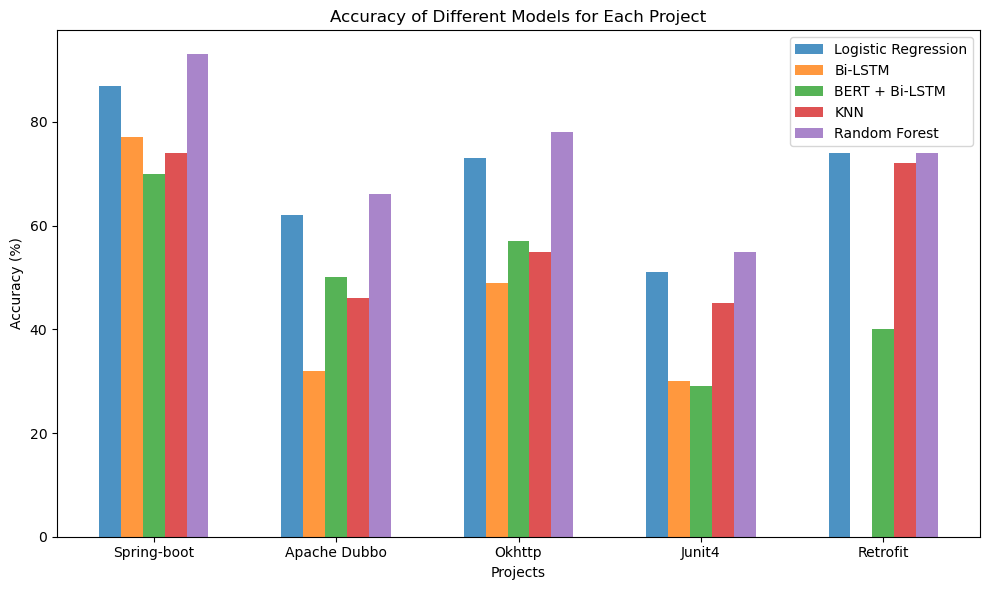

In [3]:
import numpy as np
import matplotlib.pyplot as plt


projects = ['Spring-boot', 'Apache Dubbo', 'Okhttp', 'Junit4', 'Retrofit']
models = ['Logistic Regression', 'Bi-LSTM', 'BERT + Bi-LSTM', 'KNN', 'Random Forest']

accuracy_values = np.array([
    [87, 77, 70, 74, 93],
    [62, 32, 50, 46, 66],
    [73, 49, 57, 55, 78],
    [51, 30, 29, 45, 55],
    [74, 0, 40, 72, 74]
])


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.12
opacity = 0.8
bar_offsets = np.arange(len(projects))


for i, model in enumerate(models):
    ax.bar(bar_offsets + i * bar_width, accuracy_values[:, i], bar_width, alpha=opacity, label=model)


ax.set_xlabel('Projects')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Different Models for Each Project')
ax.set_xticks(bar_offsets + (len(models) - 1) * bar_width / 2)
ax.set_xticklabels(projects)
ax.legend()


plt.tight_layout()
plt.show()
